All data is as of 2022-10-27 from <a href = https://www.kaggle.com/datasets/arthurboari/taylor-swift-spotify-data>Taylor Swift Spotify Data from Kaggle</a>

# Is the Old Taylor Really Dead?
Through this project, I will be examining the discography of famed singer-songwriter Taylor Swift. After her debut album <i>Taylor Swift</i> in 2006 she was a near instant hit, and since then has skyrocketed to fame. Using a Billboard Charts API (my implementation is in the appendix) I was able to scrape data from current and historical Billboard Charts, and using Spotify Data about Taylor Swifts discography, I was able to analyze date and acoustic information about her music. All in all, the goal of this project is to see how Taylor Swift's apparent popularity has changed over time, how her sound has changed over time, and how these changes are related.

### Part 1: Data Collection and Processing

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy
import matplotlib.axes as ax
import sklearn
import seaborn as sns
from sklearn.linear_model import *
from sklearn.datasets import *
from sklearn.discriminant_analysis import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
%run billboard_adaption.ipynb

/opt/conda/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


Note: you may need to restart the kernel to use updated packages.


While the Spotify Data Set from Kaggle proved to be a valuable resource of information, it contained far too many duplicates, singles, and special versions of her music to draw any statistical information from right away. In order to remedy this, I first set my criteria for what music I wanted to keep and what music I was going to get rid of:

- Between the Deluxe Version and the Standard Version of an album, I would keep the deluxe version, but adjust the date to that of the standard version (for purposes of retrieving all the relevant billboard charts)
- I would keep the Taylor's Version and the Original Version of any albums that she has rerecorded (there are currently two re-recorded albums <i>Fearless (Taylor's Version)</i>, and <i>Red (Taylor's Version)</i> at the time of this project). This is due to the fay ct that these albums are not exact copies of the original, were released significantly afterwards, contain many new songs, and can be a good way to model Taylor Swift's change in popularity since her early career.
- Lastly, after manually checking, I would delete non-explicit versions of albums, Karaoke Albums, Radio Remixes, Live-Performance Albums, and anything else that didn't fit the definition of a studio album.

My methodology for data scraping, very easily one of the most time consuming parts of this project, was to utilize regular expressions, as the Taylor's Version albums would be deleted if I simply deleted any name  or special "versions". There was a lot of trial and error, but I ended up being able to use a mix of regular expressions and substrings to establish whether an album was to be included in my dataset.
   

In [620]:
import warnings
warnings.filterwarnings("ignore", 'This pattern is interpreted as a regular expr')

data = pd.read_csv("Taylor Swift Spotify Data.csv")
album_filters = ['Karaoke', 'Radio', 'International', 'Disney', 'Japanese', 'Tour', 'Package', 'Platinum', 'US Version', 'Live']

for filter in album_filters:
    data = data.drop(data[data['album_name'].str.contains(filter)].index)

song_filters = ["Karaoke", "Radio", "Mix", "10 Minute Version"]
for filter in song_filters:
    data = data.drop(data[data['track_name'].str.contains(filter)].index)

album_names = data['album_name'].unique()
orig_albums = []
for name in album_names:
    if "deluxe" in name.lower() or "3am" in name.lower():
        continue
    else:
        orig_albums.append(name)
data = data.drop(data[data['album_release_date'] == "2014-01-01"].index)
data = data.drop(data[data['album_release_date'] == "2008-01-01"].index)

#print(orig_albums)
for name in orig_albums:    
    
    if("s Version" in name):
        date_fr = data[(data['album_name'].str.contains(name[0:9], regex = False)) & (data['album_name'].str.contains("s Version", regex = False))]["album_release_date"].min()
        year_fr = data[(data['album_name'].str.contains(name[0:9], regex = False)) & (data['album_name'].str.contains("s Version", regex = False))]["album_release_year"].min()
        data.loc[(data['album_name'].str.contains(name[0:9], regex = False)) & (data['album_name'].str.contains("s Version", regex = False)), "album_release_date"] = date_fr
        data.loc[(data['album_name'].str.contains(name[0:9], regex = False)) & (data['album_name'].str.contains("s Version", regex = False)), "album_release_year"] = year_fr
        #print(data[(data['album_name'].str.contains(name[0:9], regex = False)) & (data['album_name'].str.contains("s Version", regex = False))][["album_name", "album_release_date"]])
    else:

        date_fr = data[(data['album_name'].str.contains(name[0:9], regex = False)) & ~(data['album_name'].str.contains("s Version", regex = False))]["album_release_date"].min()
        year_fr = data[(data['album_name'].str.contains(name[0:9], regex = False)) & ~(data['album_name'].str.contains("s Version", regex = False))]["album_release_year"].min()

        data.loc[(data['album_name'].str.contains(name[0:9], regex = False)) & ~(data['album_name'].str.contains("s Version", regex = False)), "album_release_date"] = date_fr
        data.loc[(data['album_name'].str.contains(name[0:9], regex = False)) & ~(data['album_name'].str.contains("s Version", regex = False)), "album_release_year"] = year_fr
        #print(data[(data['album_name'].str.contains(name[0:9], regex = False)) & ~(data['album_name'].str.contains("s Version", regex = False))][["album_name", "album_release_date"]])

    #print(name + date_fr)
    
    
    
std_filters = ['^(Speak Now)$', '^(Red)$', '^1989$' , '^1989 \(Deluxe\)$', '^folklore$', '^evermore$', '^Midnights$']
for filter in std_filters:
    data = data.drop(data[data['album_name'].str.contains(filter, regex = True)].index)

#print(data["album_name"].unique())

data = data.drop_duplicates(subset=['album_name', 'track_name'], keep='first')
pd.set_option('display.max_rows', None)
#data[["album_name", "track_name", "album_release_date"]]


In order to establish a popularity metric, I needed to be able to understand when, how much, and how long Taylor Swift's songs were relevant. By using the Billboard Hot 100, I could have an understanding on where her music lined up with the rest of the music industries. Billboard also uses a more holistic point method, which takes into account physical/digital sales, streams, and radio plays. 

One issue that I ran into here, is that many of her earlier albums entered the hot 100 years after debuting, or some songs left and then reentered the chart. In order to remain accurate without sacrificing extreme runtime delays, I decided to have a variable threshold ammount (Weeks to Check before quitting) in order to remain certain that I was collectng all the data I needed. More information about how I checked the individual billboard charts can be found in the appendix.

After going through the list of songs and establishing their peak position on the chart, as well as the number of weeks they remained on the chart, I added those metrics to their corresponding rows.

In [621]:
weeks_on_chart = []
peak_on_chart = []
from IPython.display import clear_output

for index, row in data.iterrows():
    start_date = datetime.datetime.strptime(row["album_release_date"],"%Y-%m-%d")
    if row["album_name"] in ["reputation", "Taylor Swift", "Fearless"]:
        threshold = 104
    else:
        threshold = 20
    
    
    #print("Checking "+ row["track_name"] +" from "+ row["album_name"] + " starting on " + row["album_release_date"])
    slay = song_analysis_top_100(row["track_name"], start_date, threshold)
    #print("Weeks: %d Peak: %d"%(slay["weeks"], slay["peak"]))
    clear_output(wait=True)

    weeks_on_chart.append(slay["weeks"])
    peak_on_chart.append(slay["peak"])
data["weeks"] = weeks_on_chart
data["peak"] = peak_on_chart
data.sort_values(by = "album_release_date", inplace = True)
data = data.reset_index()

### Final Data: Column Names + Popularity Info
After finishing my datascraping, I was left with 39 columns of information for 235 different songs, now including the number of weeks on the Hot 100 as well as each song's peak position on the chart.

In [622]:
print("Column Names:")
cols = pd.DataFrame(data.columns.values)
display(cols)

print("Last 50 Rows:")
display(data[["album_release_date", "album_name", "track_name", "weeks", "peak"]].tail(20))

Column Names:


,0
0,index
1,artist_name
2,artist_id
3,album_id
4,album_type
5,album_release_date
6,album_release_year
7,album_release_date_precision
8,danceability
9,energy


Last 50 Rows:


,album_release_date,album_name,track_name,weeks,peak
215,2022-10-21,Midnights (3am Edition),Bejeweled,7,6
216,2022-10-21,Midnights (3am Edition),Maroon,7,3
217,2022-10-21,Midnights (3am Edition),Anti-Hero,7,1
218,2022-10-21,Midnights (3am Edition),Snow On The Beach (feat. Lana Del Rey),6,4
219,2022-10-21,Midnights (3am Edition),"You're On Your Own, Kid",6,8
220,2022-10-21,Midnights (3am Edition),Midnight Rain,7,5
221,2022-10-21,Midnights (3am Edition),Question...?,5,7
222,2022-10-21,Midnights (3am Edition),Vigilante Shit,6,10
223,2022-10-21,Midnights (3am Edition),Labyrinth,5,14
224,2022-10-21,Midnights (3am Edition),High Infidelity,3,33


# Visualizing Taylor Swifts Music

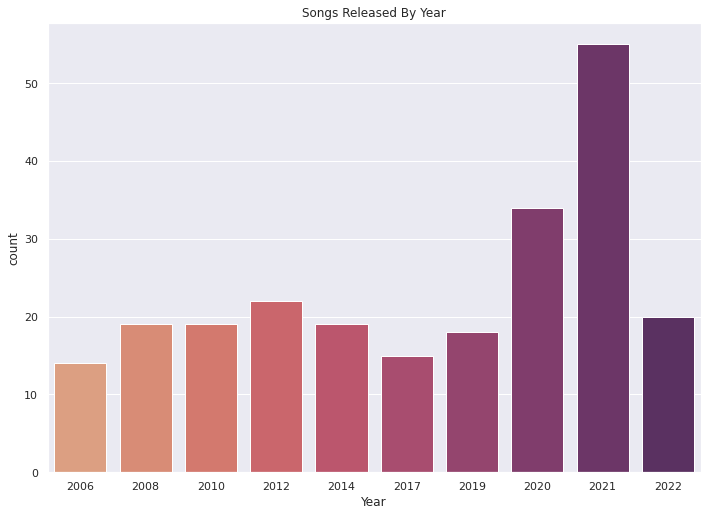

In [623]:
sns.countplot(x="album_release_year", data=data, palette = sns.color_palette("flare", 10)).set(title = "Songs Released By Year", xlabel = "Year", ylabel = "count")
plt.show()

In this graph above, we can see the number of songs that Taylor Swift released per year since her debut in 2006. Having this metric can help us develop reasoning for further metrics, such as the number of Top 100 hits as a result of volume rather than some other variable.

In [624]:
charted = data[data["peak"] > 0]
charted_by_album = charted.groupby("album_name", sort=False, as_index=False)
charted_by_year = charted.groupby("album_release_year", sort=False, as_index=False)


top_10 = []
bottom_90 = []

for album, df in charted_by_album:
    # display(df[["track_name", "album_name", "peak"]])
    # print("# top 100: " + str(df["peak"].count()))
    # print("# bottom 90: " + str(df[df["peak"] > 10]["peak"].count()))
    # print("# top 10: " + str(df[(df["peak"] <= 10) & (df["peak"] > 0)]["peak"].count()))

    bottom_90.append(df[df["peak"] > 10]["peak"].count())
    
    top_10.append(df[(df["peak"] <= 10) & (df["peak"] > 0)]["peak"].count())

# print(top_10)
charted_by_album = charted_by_album.agg({'album_release_year': 'min', 'album_release_date': 'min', 'peak': 'count', 'weeks': 'max'}).sort_values("album_release_date")

charted_by_album["bottom_90"] = bottom_90
charted_by_album["top_10"] = top_10


top_10 = []
bottom_90 = []

for album, df in charted_by_year:
    # display(df[["track_name", "album_name", "peak"]])
    # print("# top 100: " + str(df["peak"].count()))
    # print("# bottom 90: " + str(df[df["peak"] > 10]["peak"].count()))
    # print("# top 10: " + str(df[(df["peak"] <= 10) & (df["peak"] > 0)]["peak"].count()))

    bottom_90.append(df[df["peak"] > 10]["peak"].count())
    
    top_10.append(df[(df["peak"] <= 10) & (df["peak"] > 0)]["peak"].count())

# print(top_10)
charted_by_year = charted_by_year.agg({'album_release_year': 'min', 'album_release_date': 'min', 'peak': 'count', 'weeks': 'max'}).sort_values("album_release_date")

charted_by_year["bottom_90"] = bottom_90
charted_by_year["top_10"] = top_10

,album_name,album_release_year,album_release_date,peak,weeks,bottom_90,top_10
0,Taylor Swift,2006,2006-10-24,5,48,5,0
1,Fearless,2008,2008-11-11,10,50,7,3
2,Speak Now (Deluxe Edition),2010,2010-10-25,16,23,12,4
3,Red (Deluxe Edition),2012,2012-10-22,13,36,8,5
4,1989 (Deluxe Edition),2014,2014-10-27,10,50,6,4
5,reputation,2017,2017-11-10,6,35,4,2
6,Lover,2019,2019-08-23,18,22,15,3
7,folklore (deluxe version),2020,2020-07-24,16,14,13,3
8,evermore (deluxe version),2020,2020-12-10,14,20,13,1
9,Fearless (Taylor's Version),2021,2021-04-09,7,3,7,0


,album_release_year,album_release_date,peak,weeks,bottom_90,top_10
0,2006,2006-10-24,5,48,5,0
1,2008,2008-11-11,10,50,7,3
2,2010,2010-10-25,16,23,12,4
3,2012,2012-10-22,13,36,8,5
4,2014,2014-10-27,10,50,6,4
5,2017,2017-11-10,6,35,4,2
6,2019,2019-08-23,18,22,15,3
7,2020,2020-07-24,30,20,26,4
8,2021,2021-04-09,28,15,27,1
9,2022,2022-10-21,20,7,10,10


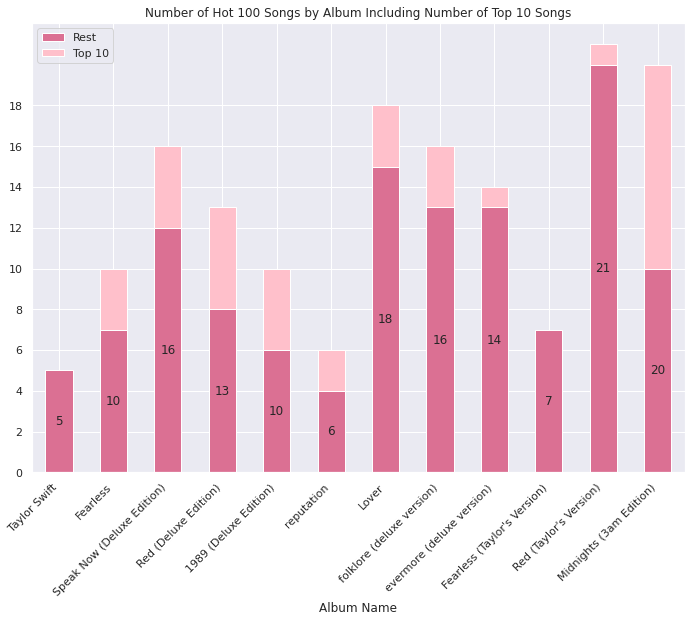

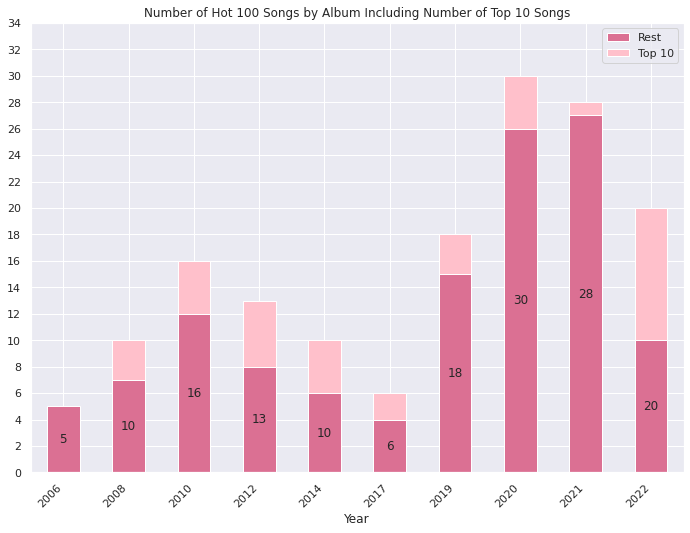

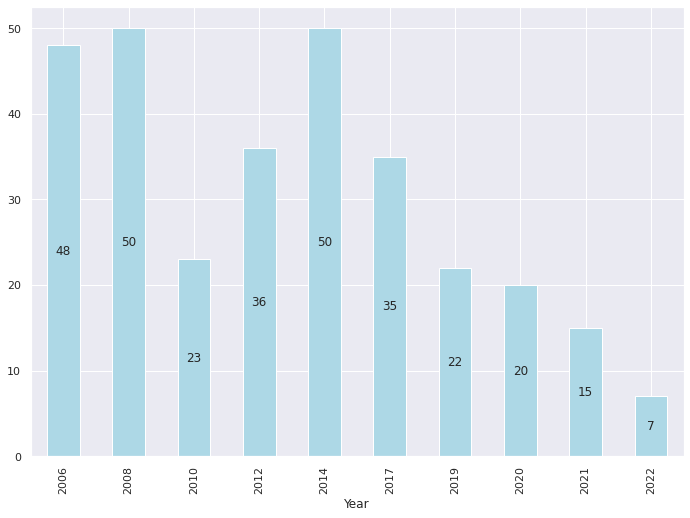

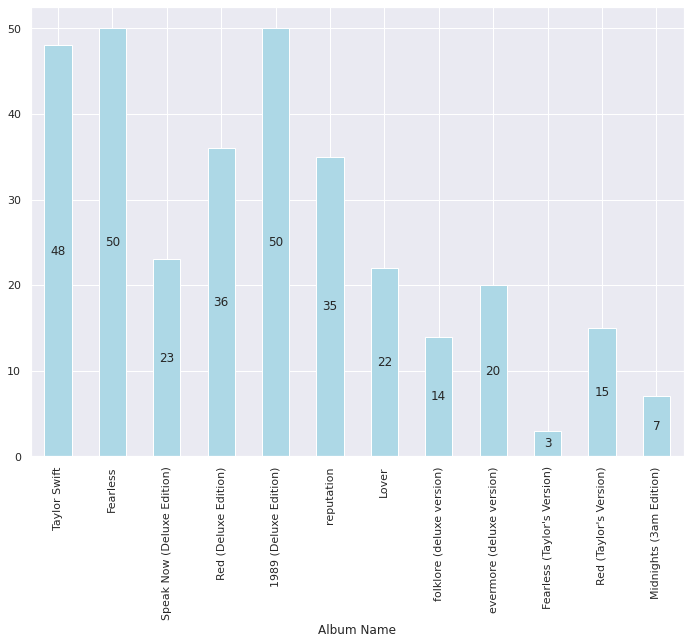

In [625]:
display(charted_by_album)
display(charted_by_year)

#display(top_100_hits[["album_name", "track_name", "album_release_date", "peak"]])


# _ = sns.barplot(x="album_name", y = "top_10", data=top_100_hits, hue_order = "album_release_year").set(title = "num top 10 songs by year", xlabel = "Year", ylabel = "count")
# _ = plt.xticks(rotation=45, ha='right')

ax = charted_by_album.plot.bar(title = "Number of Hot 100 Songs by Album Including Number of Top 10 Songs", label = ["Rest", "Top 10"], stacked=True, 
                               x = "album_name", xlabel = "Album Name", y = ["bottom_90", "top_10"], 
                               color = ["PaleVioletRed", "Pink"])
plt.bar_label(container = ax.containers[0], labels = charted_by_album["peak"].values.tolist(), label_type = "center")
plt.yticks(range(0, 20, 2))
plt.xticks(rotation=45, ha='right')
plt.show()

ax = charted_by_year.plot.bar(title = "Number of Hot 100 Songs by Album Including Number of Top 10 Songs", label = ["Rest", "Top 10"], stacked=True, 
                               x = "album_release_year", xlabel = "Year", y = ["bottom_90", "top_10"], 
                               color = ["PaleVioletRed", "Pink"])
plt.bar_label(container = ax.containers[0], labels = charted_by_year["peak"].values.tolist(), label_type = "center")
plt.yticks(range(0, charted_by_year["peak"].max() + 5 , 2))
plt.xticks(rotation=45, ha='right')
plt.show()

ax = charted_by_year.plot.bar(title = "Number of Weeks on Hot 100 Songs by Year Including Number of Top 10 Songs", x = "album_release_year", xlabel = "Year", ylabel = "Weeks", y = "weeks", color = "lightblue",legend = False)
plt.bar_label(container = ax.containers[0], labels = charted_by_year["weeks"].values.tolist(), label_type = "center")
plt.show()


ax = charted_by_album.plot.bar(title = "Number of Weeks on Hot 100 Songs by Album Including Number of Top 10 Songs", x = "album_name", xlabel = "Album Name", y = "weeks", ylabel = "Weeks", color = "lightblue",legend = False)
plt.bar_label(container = ax.containers[0], labels = charted_by_album["weeks"].values.tolist(), label_type = "center")
plt.show()

In the Above 4 graphs, we can see the number of Billboard Hot 100 entries Taylor Swift received through her 10 studio albums and 2 re-recordings, as well as the same info displayed on a per year basis. As they are listed in chronological order, this also gives us a sense of how her audience's listening habits have changed over time. While there has been a sharp increase in the amount of Hot 100 entries, and even more notably in the Top 10 entries on top of that, it is possible that this is accredited to the release of so many songs during a short time period. As we saw, Taylor Swift nearly 60 songs in 2021 versus just over 20 in 2012, this is reflected by her Top 100 stats with 28 Hot 100 entries in 2021, and 13 in 2012.

Another interesting statistic is that while the increased output of her music resulted in more songs entering the Hot 100, it did not improve their longevity on the chart, in fact there was an overall decreasing trend in the amount of weeks a song stayed on the chart (Each album/year is represented by the song with the longest standing). This may point to a variety of things, such as a potential decrease in the quality of Taylor Swift's work, or perhaps, a result of her released re-recordings, which for the purposes of this project count as new songs, but to listeners, may not be as exciting. For instance, her latest album <i>Midnights</i>, occupied the entire Top 10 as indicated by the chart, and since its release on 10/21, has remained on the chart. While there does seem to be a lot to unpack from this graph, I think that the re-recordings and lack of future-sight for Midnights success leaves much to be known. 

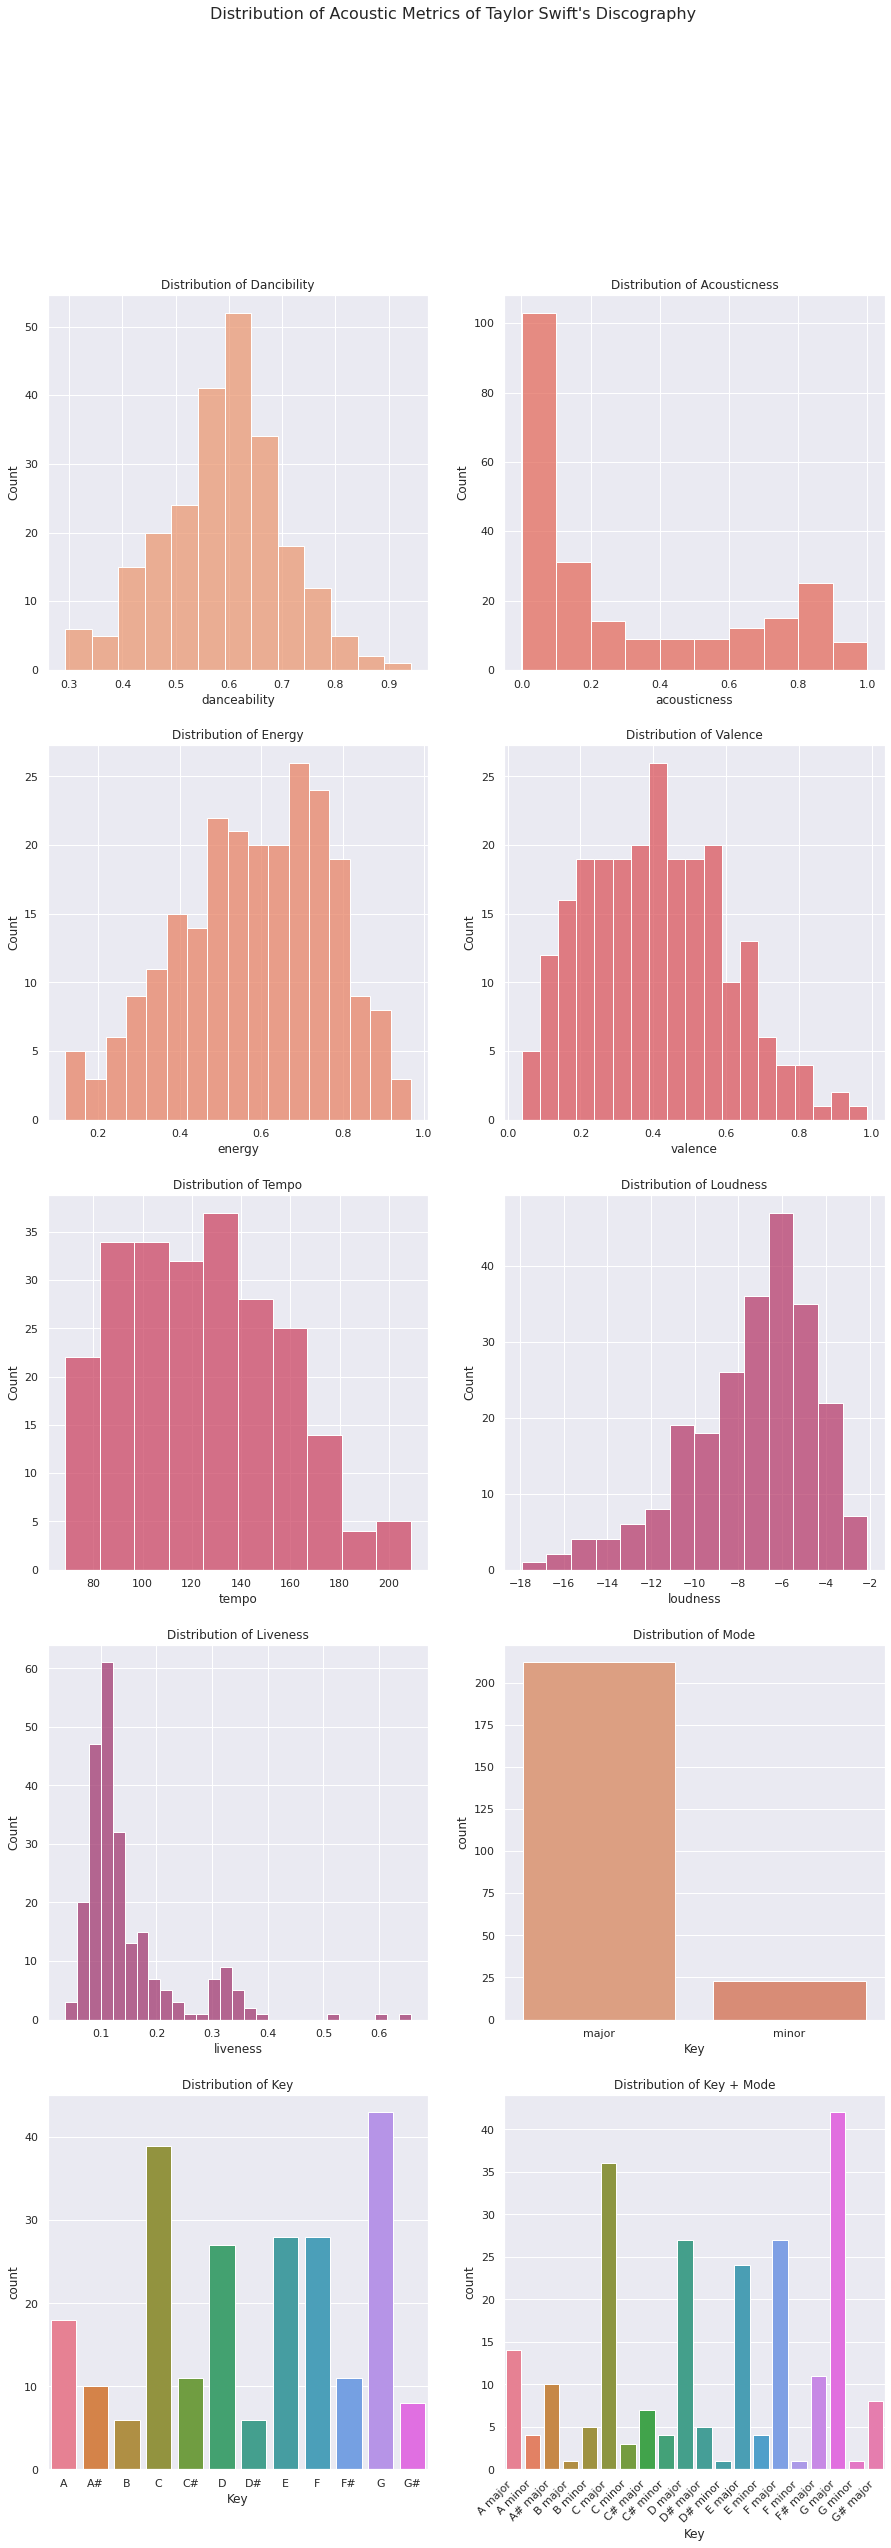

In [626]:
#datetimes = pd.to_datetime(data["album_release_date"], format="%Y-%m-%d").values.astype(numpy.int64)
fig, axs = plt.subplots(5, 2, figsize=(15, 40))


sns.histplot(data = data, x = "danceability", binwidth = 0.05, stat = "count", 
              color = sns.color_palette("flare", 10)[0], legend = False, ax = axs[0, 0]).set_title(label = "Distribution of Dancibility")

sns.histplot(data = data, x = "energy", binwidth = 0.05, stat = "count", 
              color = sns.color_palette("flare", 10)[1], legend = False, ax = axs[1, 0]).set_title(label = "Distribution of Energy")

sns.histplot(data = data, x = "acousticness", binwidth = 0.1, stat = "count", 
             color = sns.color_palette("flare", 10)[2], legend = False, ax = axs[0, 1]).set_title(label = "Distribution of Acousticness")

sns.histplot(data = data, x = "valence", binwidth = 0.05, stat = "count", 
             color = sns.color_palette("flare", 10)[3], legend = False, ax = axs[1, 1]).set_title(label = "Distribution of Valence")

sns.histplot(data = data, x = "tempo", stat = "count", 
             color = sns.color_palette("flare", 10)[4], legend = False, ax = axs[2, 0]).set_title(label = "Distribution of Tempo")

sns.histplot(data = data, x = "loudness", stat = "count", 
             color = sns.color_palette("flare", 10)[5], legend = False, ax = axs[2, 1]).set_title(label = "Distribution of Loudness")

sns.histplot(data = data, x = "liveness", stat = "count", 
             color = sns.color_palette("flare", 10)[6], legend = False, ax = axs[3, 0]).set_title(label = "Distribution of Liveness")                                                                                     

sns.countplot(order=data["mode_name"].sort_values().unique(), x="mode_name", 
              data=data, ax = axs[3, 1], palette = sns.color_palette("flare", 10)).set(
                title = "Distribution of Mode", xlabel = "Key", ylabel = "count")

sns.countplot(order=data["key_mode"].sort_values().unique(), x="key_mode", 
              data=data, palette = sns.color_palette("husl", 20), ax = axs[4, 1]).set(
                title = "Distribution of Key + Mode", xlabel = "Key", ylabel = "count")
plt.xticks(rotation=45, ha='right')

                                                                                                  
sns.countplot(order=data["key_name"].sort_values().unique(), x="key_name", 
              data=data, palette = sns.color_palette("husl", 13), ax = axs[4, 0]).set(
                title = "Distribution of Key", xlabel = "Key", ylabel = "count")


fig.suptitle("Distribution of Acoustic Metrics of Taylor Swift's Discography", fontsize=16)
plt.show()

In this figure we have several acoustic metrics provided to us by the Spotify Data set. This includes danceability, valence (how happy a song sounds), tempo, loudness, liveness, mode, and key. The following helps us illustrate Taylor Swift as a musicion and see distinct trends in her music. For instance, the a large portion of Taylor Swift's songs are made with major chords, and within this, the most common keys are C Major, and G Major. For the more subjective metrics, we can still see trends that can describe her music to us. For instance in Graph 2, we see that her songs are largely non-acoustic, but they can also be very acoustic. This can lead us to believe that while Taylor swift largely makes non-acoustic songs, if she does, these songs are almost completely acoustic and very rarely in the middle. Many of the other metrics, such as Danceability, Energy, Valence, and Loudness, all follow a normal distribution, with most of taylor swift songs being centered around some average danceability, energy, etc.  

# Trends in Acoustic Data vs Popularity

#### Acoustic Metrics with Peak Position

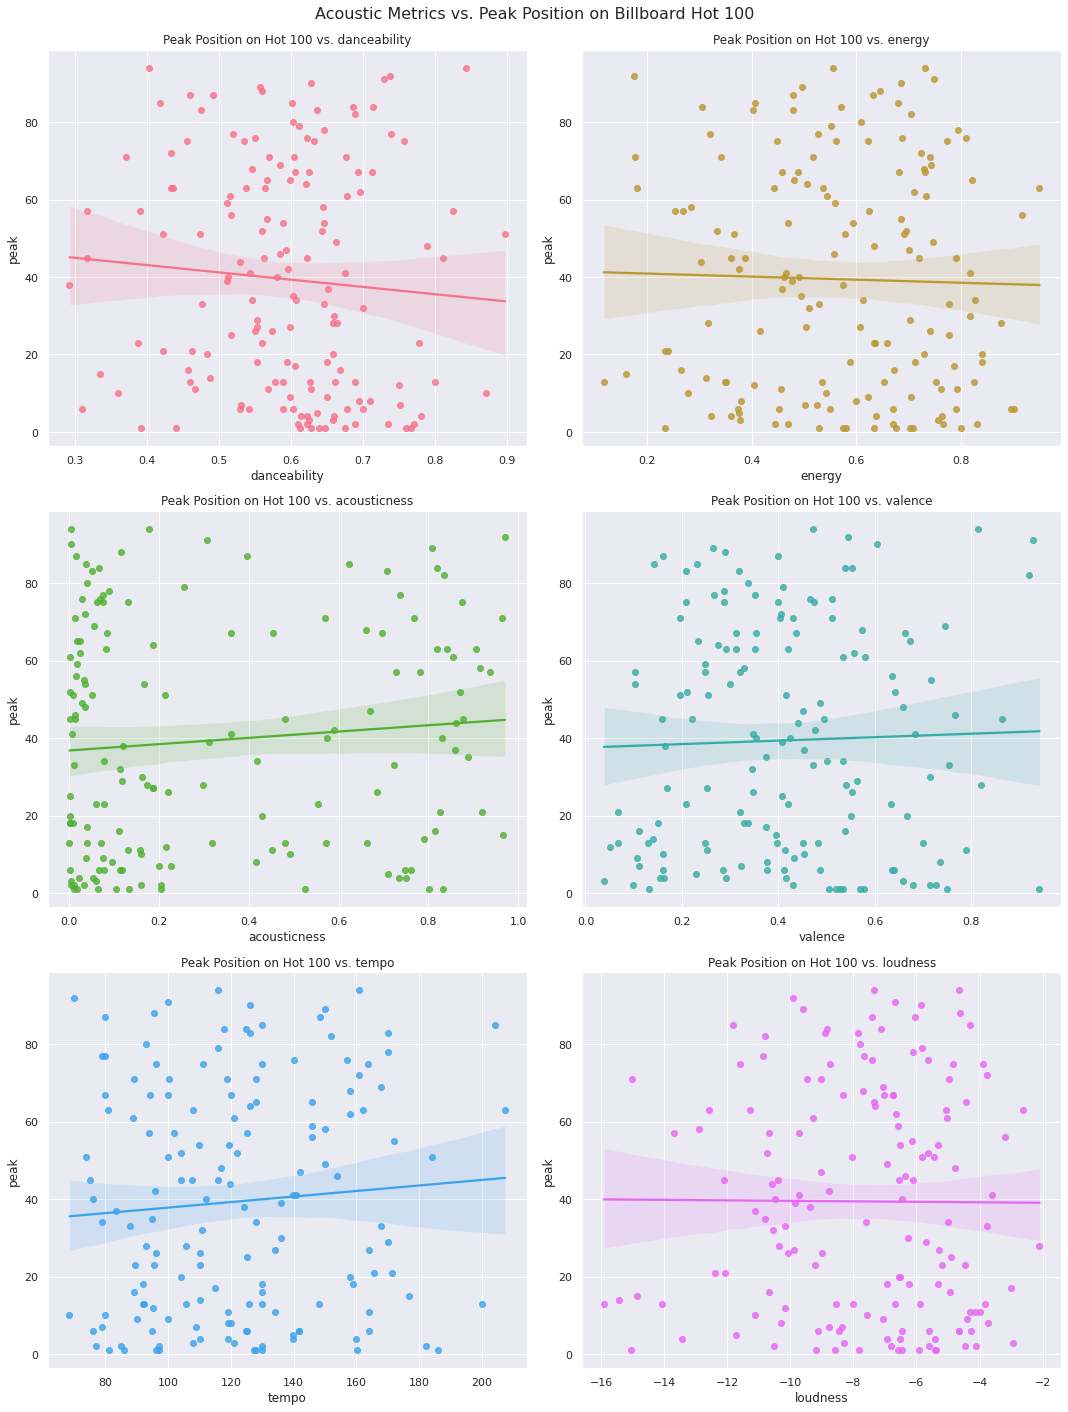

In [627]:
fig, axs = plt.subplots(3, 2, figsize=(15, 20))
i=0

for metric in ["danceability", "energy", "acousticness", "valence", "tempo", "loudness"]:
    col = int(i%2)
    row = int(i/2)
    a = sns.regplot(data = charted, x = metric, y = "peak", 
                color = sns.color_palette("husl", 6)[i], ax = axs[row, col]).set_title("Peak Position on Hot 100 vs. " + metric)
    i += 1
fig.suptitle("Acoustic Metrics vs. Peak Position on Billboard Hot 100", fontsize = 16)
fig.tight_layout()
plt.subplots_adjust(top=.95)
a = plt.show

Moving on to correlating data, here we try to associate the different acoustic metrics with the peak position on the chart for each individual song. I only included songs that appeared on the chart in order to avoid zero-inflation.Its important to note that here a negative relationship (Peak goes down as *metric* goes up) is a good thing, as the highest position a song can have is 1. Although there seem to be slight correlations, there is a lot of noise, and it is difficult to certainly say that any of the Acoustic Metrics have an impact on how well a song does.

#### Acoustic Metrics with Weeks on Chart

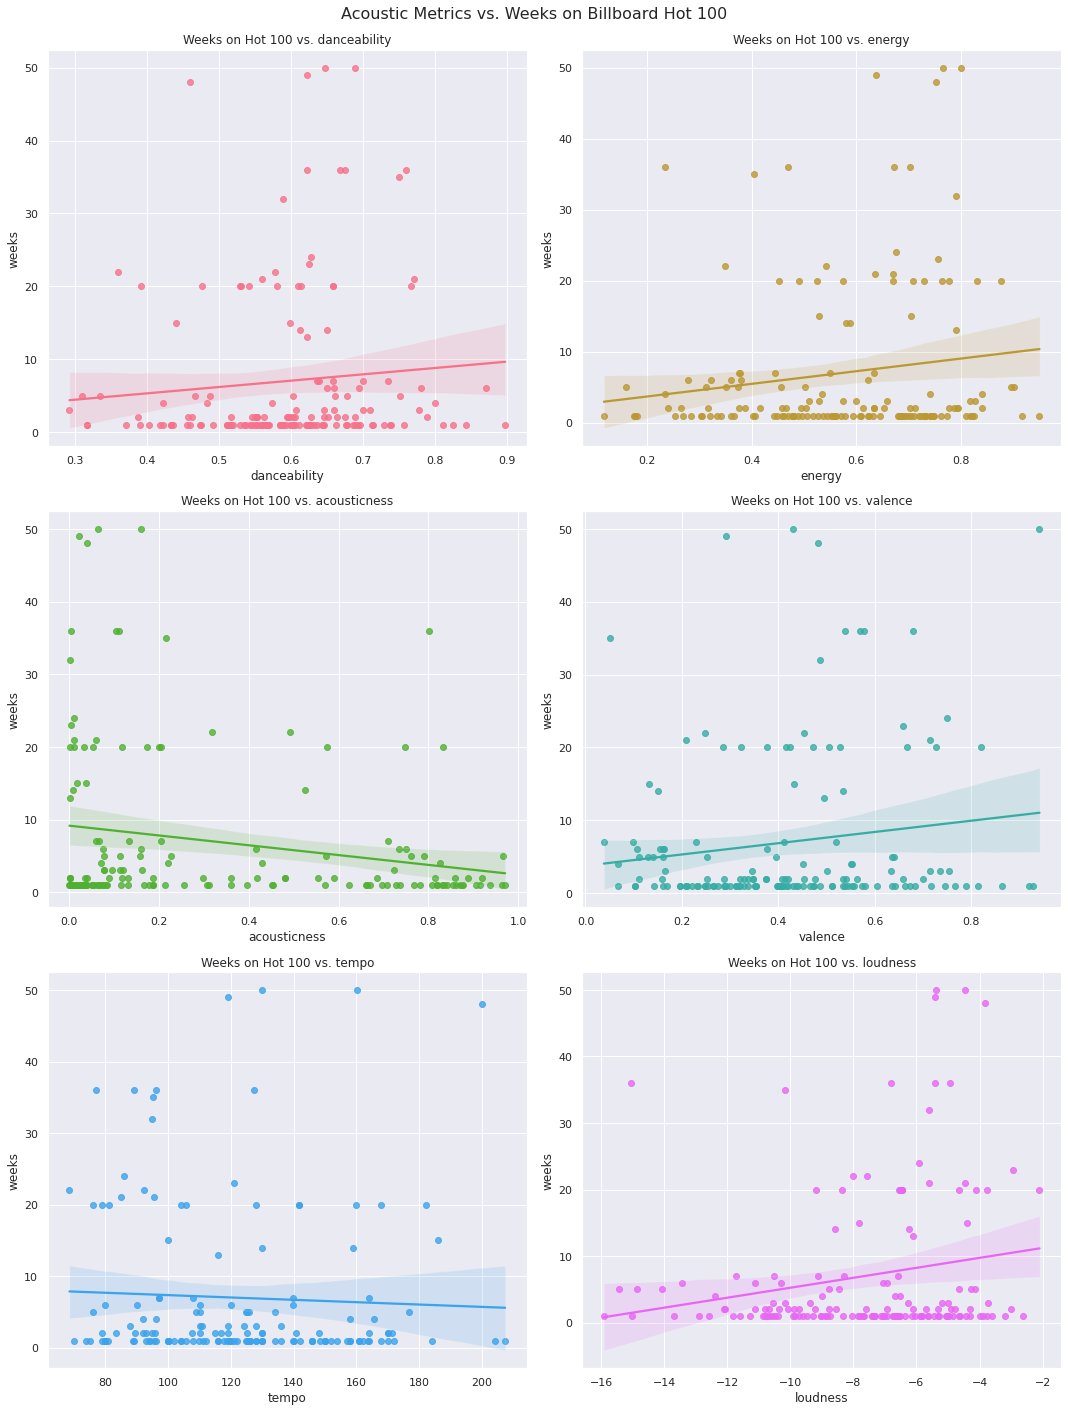

In [628]:
fig, axs = plt.subplots(3, 2, figsize=(15, 20))
i=0

for metric in ["danceability", "energy", "acousticness", "valence", "tempo", "loudness"]:
    col = int(i%2)
    row = int(i/2)
    a = sns.regplot(data = charted, x = metric, y = "weeks", 
                color = sns.color_palette("husl", 6)[i], ax = axs[row, col]).set_title("Weeks on Hot 100 vs. " + metric)
    i += 1
fig.suptitle("Acoustic Metrics vs. Weeks on Billboard Hot 100", fontsize = 16)
fig.tight_layout()
plt.subplots_adjust(top=.95)
a = plt.show

Continuing with correlating data, here we associate the acoustic metrics with the number of weeks each song spent on on the chart. I only included songs that appeared on the chart in order to avoid zero-inflation. Unlike the Peak-Position graph, a positive correlation is good in this scenario, as we want the songs to have longevity on the chart. While most of these charts have large standard deviations that may make them unusable for statistical purposes, acousticness seems to have a relatively close relationship with weeks spent on the chart. If a song is more acoustic, it tends to spend less time on the chart. This may be a result of changing music consumption through mediums like TikTok which promote more upbeat and dancible music.  

# Accounting for Sensationalism
While correlating all data that appears on a Billboard chart would seem to give us a good idea of what does and doesn't make a popular song, there is a very important aspect it didn't account for. As mentioned earlier, Taylor Swift's latest album <i>Midnights (3AM Version)</i> resulted in all 20 tracks appearing on the Hot 100 and occupying the entire Top 10. While these songs did do very well in their debut, that is not necesarily a sign that they will continue to be popular. Since we can't expect them to all be acoustically identical, it isn't safe to say that we can use them to evaluate data about the relationship between Acoustic Metrics and popularity. As a result, I created a second set of graphs to evaluate the relationship between the Acoustic Metrics and Peak/Week data under the condition that a song had been on the chart for at least 5 weeks.

#### Peak Position of Top 10 songs vs Acoustic Metrics

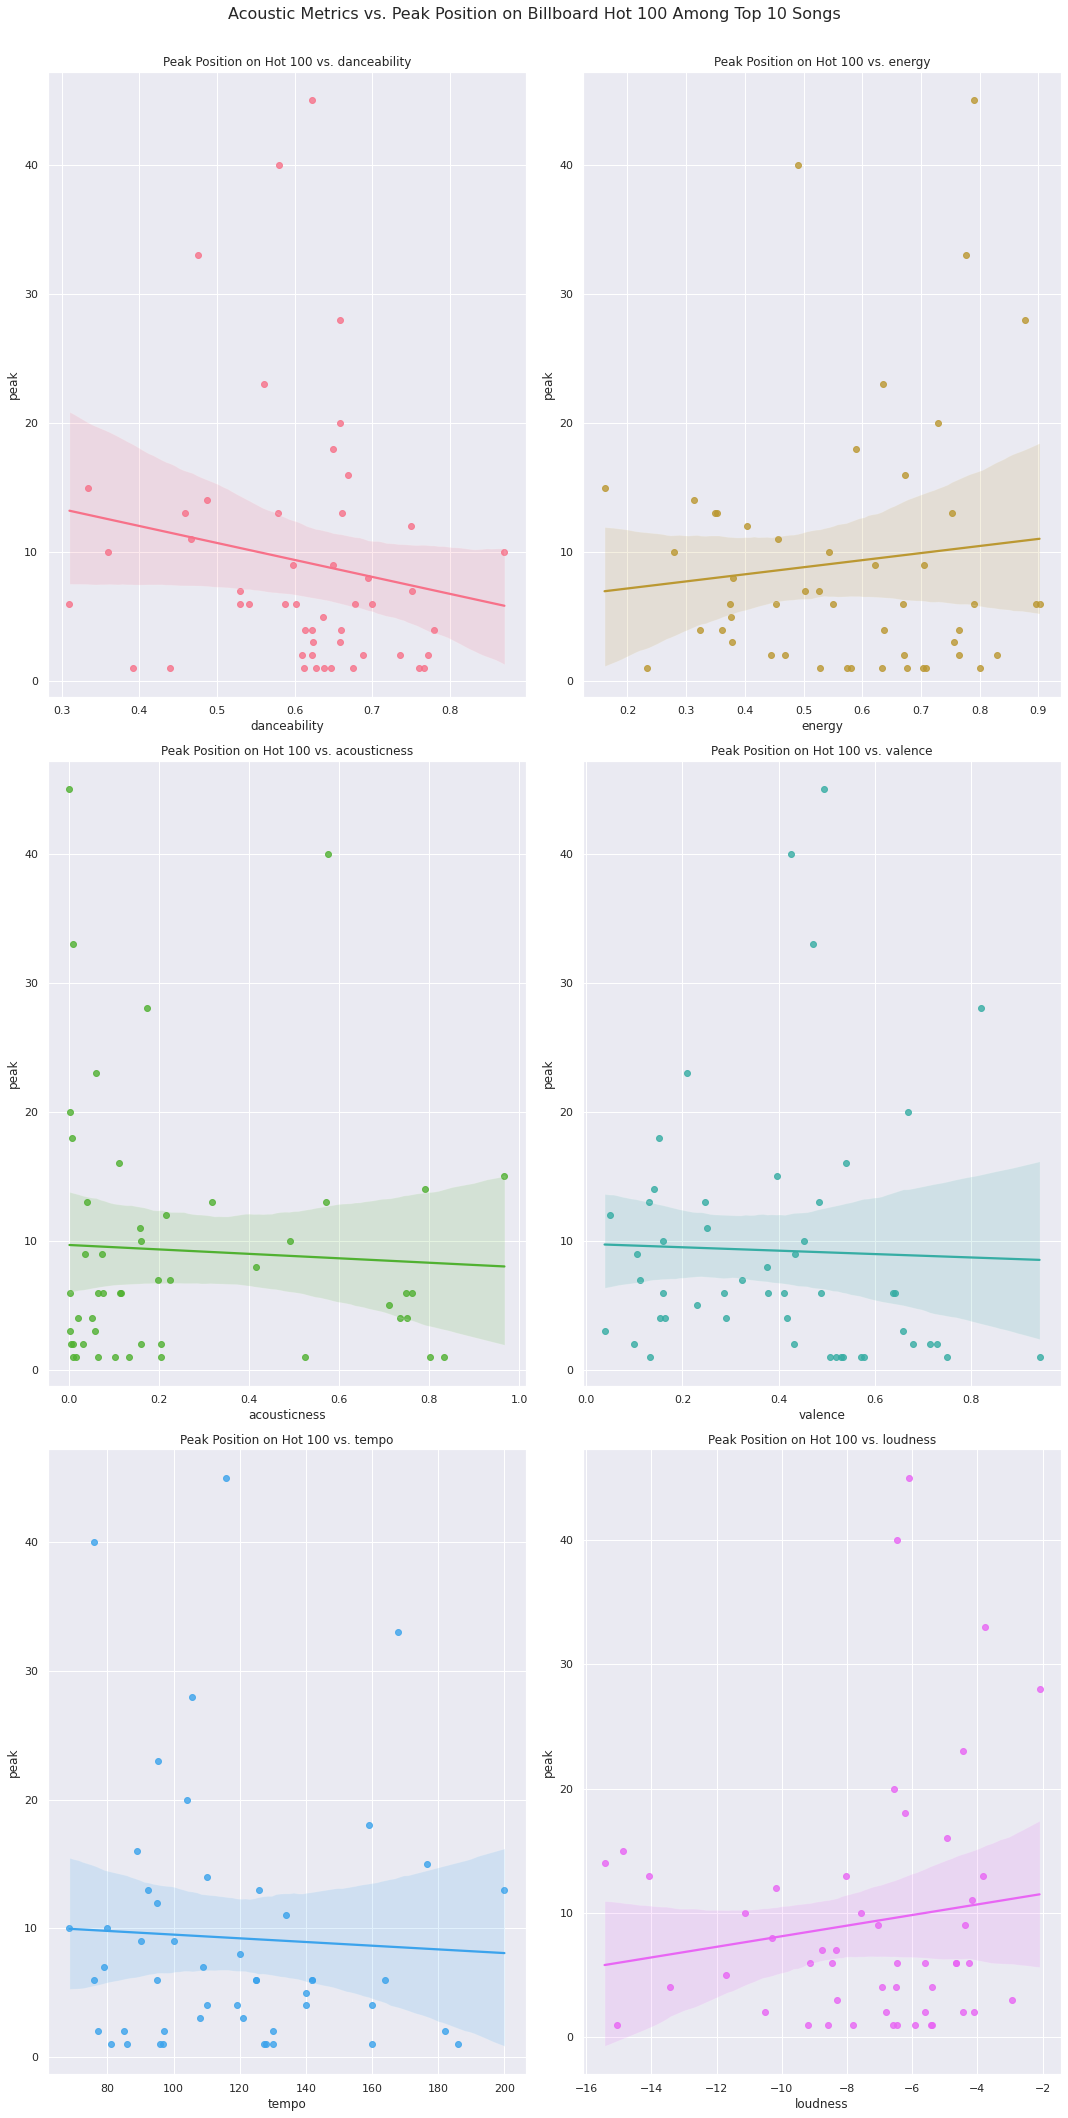

In [629]:
fig, axs = plt.subplots(3, 2, figsize=(15, 30))
i=0
weeks_10 = data[(data["weeks"] >= 5)]

for metric in ["danceability", "energy", "acousticness", "valence", "tempo", "loudness"]:
    col = int(i%2)
    row = int(i/2)
    a = sns.regplot(data = weeks_10, x = metric, y = "peak", 
                color = sns.color_palette("husl", 6)[i], ax = axs[row, col]).set_title("Peak Position on Hot 100 vs. " + metric)
    i += 1
fig.suptitle("Acoustic Metrics vs. Peak Position on Billboard Hot 100 Among Top 10 Songs", fontsize = 16)
fig.tight_layout()
plt.subplots_adjust(top=.95)
a = plt.show

Using this new dataset, there is far less noise, and more statistical relevance between the two. For instance, danceability, acousticness, valence, and tempo all seem to improve a songs position on the Hot 100, while loudness and energy hurt it. 

#### Weeks on Billboard Hot 100 vs Acoustic Metrics Among Songs That Have Charted for at Least 10 Weeks

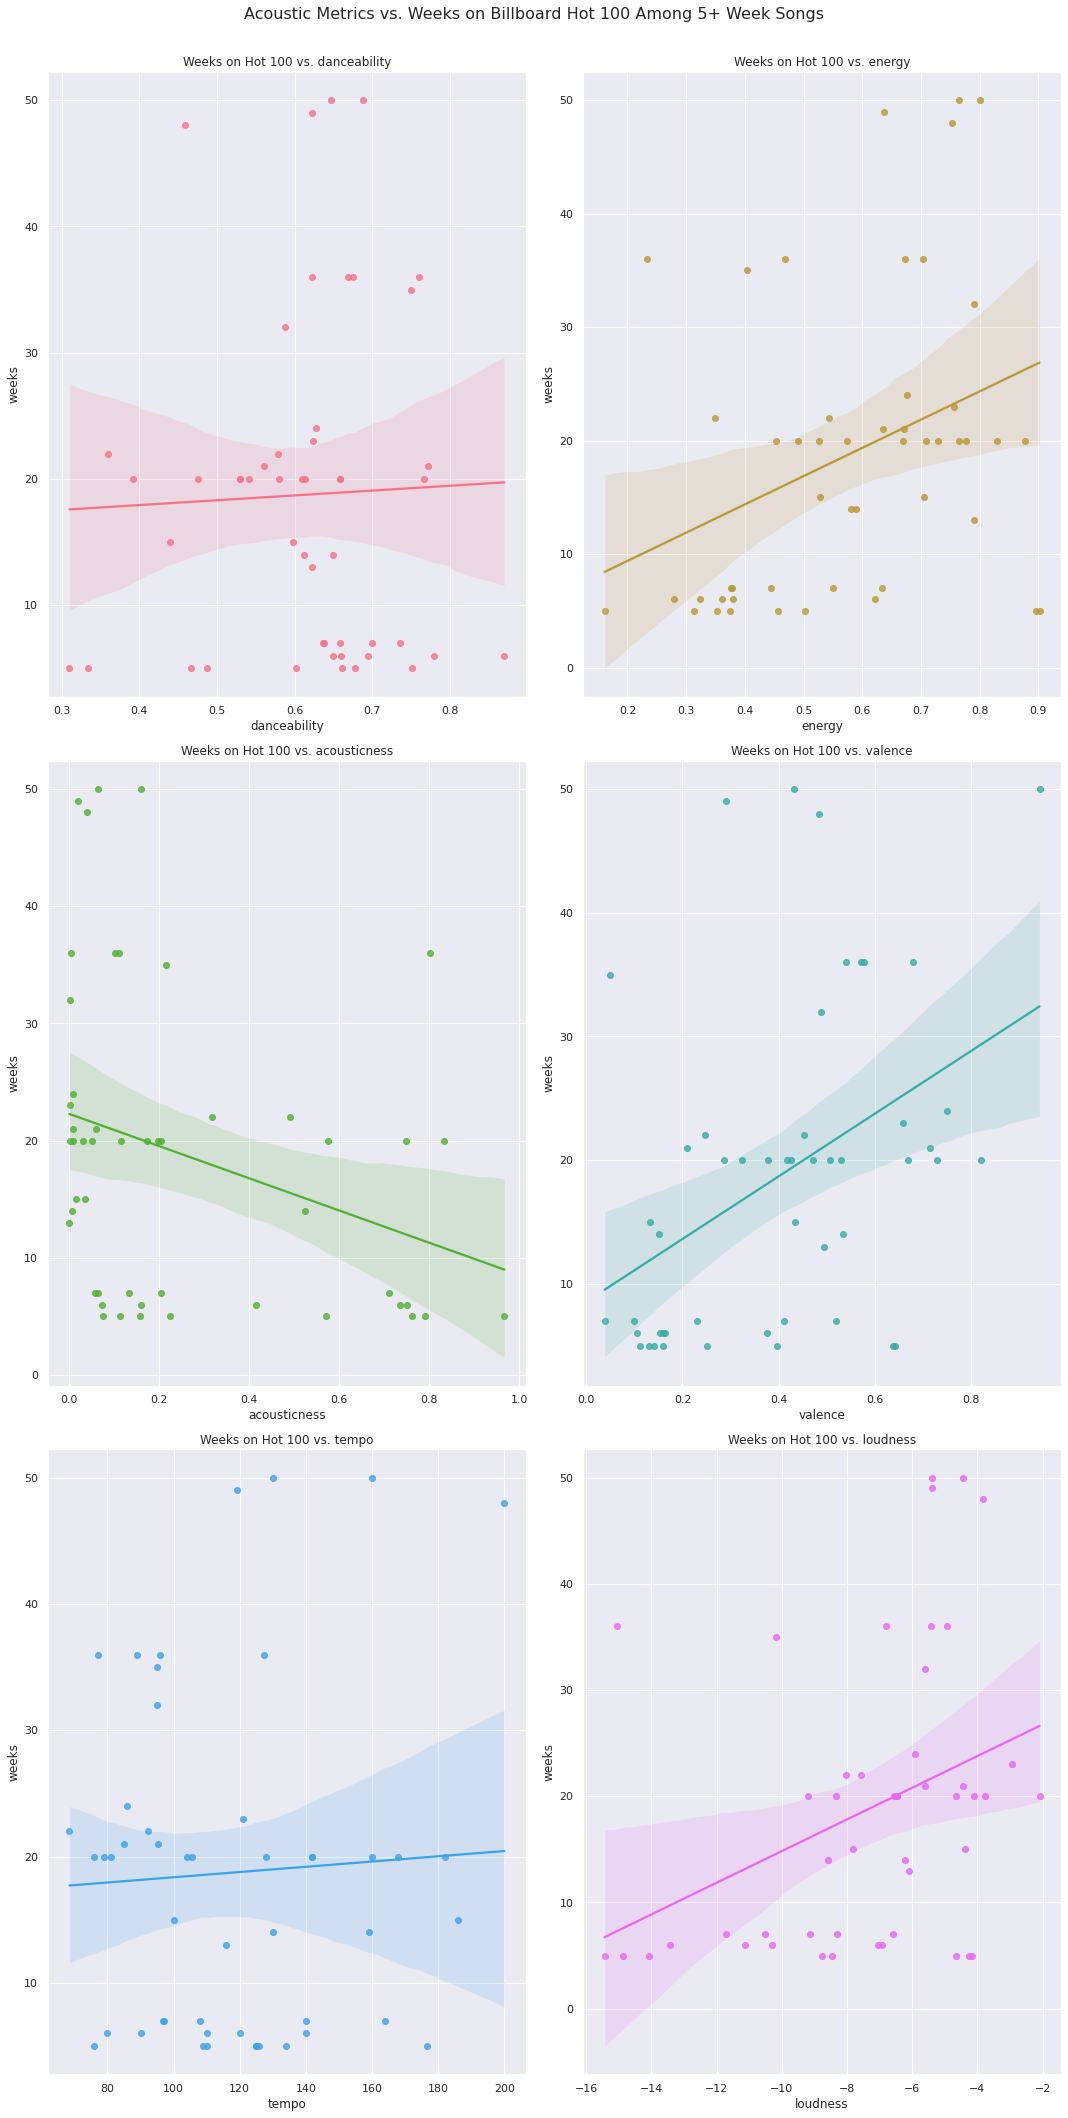

In [630]:
fig, axs = plt.subplots(3, 2, figsize=(15, 30))
i=0
weeks_10 = data[(data["weeks"] >= 5)]

for metric in ["danceability", "energy", "acousticness", "valence", "tempo", "loudness"]:
    col = int(i%2)
    row = int(i/2)
    a = sns.regplot(data = weeks_10, x = metric, y = "weeks", 
                color = sns.color_palette("husl", 6)[i], ax = axs[row, col]).set_title("Weeks on Hot 100 vs. " + metric)
    i += 1
fig.suptitle("Acoustic Metrics vs. Weeks on Billboard Hot 100 Among 5+ Week Songs", fontsize = 16)
fig.tight_layout()
plt.subplots_adjust(top=.95)
a = plt.show

Using this new dataset, there significantly less noise, and much stronger statistical relevance between the acousitc measures and the number of weeks spent on the chart. For instance, energy, valence, and loudness all seem to improve a songs longevity, and the number of weeks is much more definatively negatively correlated with acousticness.

# Conclusion

While the data provided seems to point towards correlations between some metrics of Taylor Swift's discography and the popularity of the song, there is a lot of speculation about how precise these correlations actually are. Overall, I think the most important insight was that while the number of entries on the Top 100 increased, the number of weeks that a song stayed on the chart decreased, which opens a lot of doors for more analysis. For the scope of this project, further investigation may not have been possible, but future improvements could improve the inclusion of linear regression using multiple simultaneous columns of data to evaluate the popularity of the song, and predictions about how the <i>Taylor's Version</i> re-recordings perform on the charts in comparison to the originals, as well as projecting the success of the upcoming rerecordings. 

# Appendix

### Billboard Retrieval Code
This is the method I created to pull peak and week information from the billboard charts. I used <a href = https://github.com/guoguo12/billboard-charts>this</a> api from guoguo12 on GitHub to implement it!

In [637]:
pip install -q git+https://github.com/guoguo12/billboard-charts.git

Note: you may need to restart the kernel to use updated packages.


In [638]:
import billboard
import datetime

In [639]:
saved_charts = {}

After running this program on a test album, it became aparent that querying from Billboard was a very costly task. Since each song on the album shares a release date, I thought it would be a good idea to create a dictionary of chart objects (what billboard.ChartData() returns) in order to speed up the process in the long run. After the algorithm checks 20+ weeks of charts for a song, those charts are then saved, and can be very quickly retrieved for future songs. The rest of the algorithm works by stripping string inforation from the returned Chart Object and saving it to a dictionary, containing the Weeks and Peak Position for the requested song.

In [ ]:
def song_analysis_top_100(song_name, release_date, threshold=20):
    data = {"weeks": 0, "peak": 0}
    weeks = 0
    today = datetime.datetime.now()
    date_itr = release_date
    weeks_missing = 0
    
    
    while date_itr <= today and weeks_missing < threshold:
        date_string = date_itr.strftime("%Y-%m-%d")
        #print("Checking Billboard Top 100 For: " + date_string)
        if date_string in saved_charts:
            chart = saved_charts[date_string]
        else:
            chart = billboard.ChartData('hot-100', date = date_string, fetch=True, timeout=25)
            saved_charts[date_string] = chart
        for song in chart:
            #print(song.title.strip().lower().replace('\’','\''))
            #print(song_name.strip().lower().replace('\’','\''))
            if song.title.strip().lower().replace('’','\'') in song_name.strip().lower().replace('’','\'') and "Taylor Swift" in song.artist:
                #print(song.weeks)
                data["weeks"] = song.weeks
                data["peak"] = song.peakPos
                weeks_missing = 0
        weeks_missing += 1
        date_itr = date_itr + datetime.timedelta(days=7)
    return data
